<a href="https://colab.research.google.com/github/olfabre/amsProjetSemestre2/blob/main/05_03_LSTM_bi_avec_Attention_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Entraînement sur le dataset de mots de passe...
 31s (1000 33%) 3.6174]
 2s (2000 66%) 3.4088]
 35s (3000 100%) 3.3470]


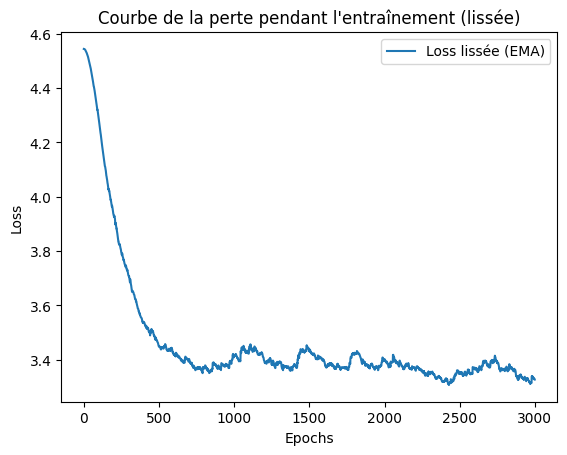


Génération de mots de passe après entraînement :

t07h1heeaaca
swenaa1
&20yv40a9a
oa8ecado4rj
[3daaa
CSsf3s2
8aeu12c8a1soy
$a1kals
.ausaha214a9a
wagoxnx5aa


In [10]:
# Installer unidecode si nécessaire
!pip install unidecode

import string
import random
import torch
import torch.nn as nn
import time, math
import matplotlib.pyplot as plt
from os import path, makedirs
from unidecode import unidecode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensembles des caractères pour les mots de passe
all_characters = string.ascii_letters + string.digits + string.punctuation
selected = string.ascii_letters + string.digits + string.punctuation
not_selected = string.whitespace
n_characters = len(all_characters)

chunk_len = 12
hidden_size = 256
n_layers = 2
lr = 0.005
n_epochs = 3000

# Chargement des données
file = unidecode(open("sample_data/train2.txt").read())
file_len = len(file)

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len - 1)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        if string[c] in not_selected:
            continue
        tensor[c] = selected.index(string[c])
    return tensor.to(device)

def random_training_set():
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# LSTM bidirectionnel avec Attention corrigé
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super(BiLSTMWithAttention, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, bidirectional=True, batch_first=True)

        # Correction : attention adaptée à un LSTM bidirectionnel
        self.attn = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, -1, hidden_size)
        output, (hn, cn) = self.lstm(x, hidden)

        # Mécanisme d'attention corrigé
        attn_weights = torch.softmax(self.attn(output.squeeze(0)), dim=1)
        attn_output = output.squeeze(0) * attn_weights  # Application de l'attention
        output = self.fc(attn_output)

        return output, (hn, cn)

    def init_hidden(self):
        return (torch.zeros(n_layers * 2, 1, hidden_size, device=device),
                torch.zeros(n_layers * 2, 1, hidden_size, device=device))

# Initialisation du modèle
decoder = BiLSTMWithAttention(n_characters, hidden_size, n_characters, n_layers).to(device)
optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []  # Stockage des pertes

# Fonction d'entraînement
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    seq_len = inp.size(0)

    for c in range(seq_len):
        output, hidden = decoder(inp[c].unsqueeze(0), hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    optimizer.step()

    all_losses.append(loss.item() / seq_len)
    return loss.item() / seq_len

# Fonction de génération de mots de passe
def evaluate(prime_str='A', predict_len=None, temperature=0.8):
    if predict_len is None:
        predict_len = random.randint(5, 12)

    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p].unsqueeze(0), hidden)
    inp = prime_input[-1]

    for _ in range(predict_len):
        output, hidden = decoder(inp.unsqueeze(0), hidden)
        output_dist = torch.softmax(output.view(-1) / temperature, dim=0)
        top_i = torch.multinomial(output_dist[:len(selected)], 1)[0]
        predicted_char = selected[top_i]
        predicted += predicted_char
        inp = torch.tensor([top_i], dtype=torch.long).to(device)

    return predicted

# Fonction pour mesurer le temps écoulé
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Lissage exponentiel des pertes
def exponential_moving_average(values, alpha=0.01):
    ema = []
    avg = values[0]
    for value in values:
        avg = alpha * value + (1 - alpha) * avg
        ema.append(avg)
    return ema

# Lancement de l'entraînement
print("Entraînement sur le dataset de mots de passe...")
start = time.time()

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())
    if epoch % 1000 == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

# Affichage de la courbe de perte
smoothed_losses = exponential_moving_average(all_losses, alpha=0.01)
plt.plot(smoothed_losses, label='Loss lissée (EMA)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de la perte pendant l\'entraînement (lissée)')
plt.legend()
plt.show()

# Sauvegarde du modèle
if not path.exists("models"):
    makedirs("models")
torch.save(decoder, "models/password_lstm_attention.pt")

# Génération de mots de passe après entraînement
print("\nGénération de mots de passe après entraînement :\n")
for _ in range(10):
    random_length = random.randint(5, 12)
    print(evaluate(prime_str=random.choice(selected), predict_len=random_length, temperature=0.7))
